## Acoustics Simulation

This notebook is an MRE of an 1D acoustics simulation in a battery.

It can be divided into four steps: (1) Setting cell parameters, (2) setting simulation parameters, (3) running simulation, and (4) viewing the results.

In [14]:
%matplotlib inline

from IPython.display import HTML

from acoustics import figures, utils

Read in data from Voltaiq.

**NOTE**: This block can only be run in VAS.

In [5]:
from acoustics import voltaiq

all_data = voltaiq.load_from_vs()
keyword = 'UM '
dataset = voltaiq.filter_by_keyword(dataset=all_data, keyword=keyword)

### 1. Cell Properties

This example manually sets SoC at 50%, but it can be programmatically be calculated from utils.soc() where voltage from `dataset` is an input.

In [7]:
keys = ['name', 'E', 'rho', 'x', 'alpha']
no_stacks = 2

layers_raw = {
    'case': [70e9, 2700, 100e-6, 0.7],
    'copper': [130e9, 8960, 10e-6, 0.5],
    'anode': [10e9, 2260, 60e-6, 0.6],
    'electrolyte': [2e9, 1000, 50e-6, 1.2],
    'separator': [2e9, 920, 20e-6, 1.1],
    'cathode': [200e9, 3300, 50e-6, 0.5],
    'aluminum': [70e9, 2700, 10e-6, 0.7]
}

E_index = 0
layers_raw['anode'][E_index], layers_raw['cathode'][E_index] = utils.adjust_stiffness(
    soc = 0.5,
    E_anode_0=layers_raw['anode'][E_index],
    E_cathode_0=layers_raw['cathode'][E_index]
)

rho_index = 1
layers_raw['anode'][rho_index], layers_raw['cathode'][
    rho_index] = utils.adjust_stiffness(
        soc=0.5,
        E_anode_0=layers_raw['anode'][rho_index],
        E_cathode_0=layers_raw['cathode'][rho_index])

layers = utils.stack_layers(keys=keys,
                            layers_raw=layers_raw,
                            no_stacks=no_stacks)
cell = utils.assemble_cell(layers=layers)
utils.save_cell(cell=cell)

### 2. Simulation Properties

In [8]:
props = {
    'Nx': 512,  # number of grid points in the x (row) direction
    'cfl': 0.2,  # Courant-Friedrichs-Lewy number: For ensuring convergence
    'simulation_duration': 1e-6,  # [s]
    'source_freq': 25e6,  # [Hz]
    'source_mag': 4,  # [Pa]
    'alpha_power': 1.5,  # Attenuation
}

utils.save_properties(properties=props)

### 3. Simulation

The simulation engine is in MATLAB. This block cannot be run from this notebook in VAS due to MATLAB licensing limitations.

There are at the time of writing two solutions when running in VAS:

1. The user switches to the MATLAB IDE (from New Launcher, upper left), run it there and then return to this notebook, omitting this block. WARNING: This takes a long time to run in MATLAB online

2. Omit the simulation run altogether and move on to the next block. This is possible as an example simulation data file (`simulation.h5`) is included in the showcase

In [ ]:
from acoustics import simulation

simulation.run()

In [22]:
simulation_ = utils.fetch_simulation()

### 4. View Results

Sensor pressure amplitude as a function of time

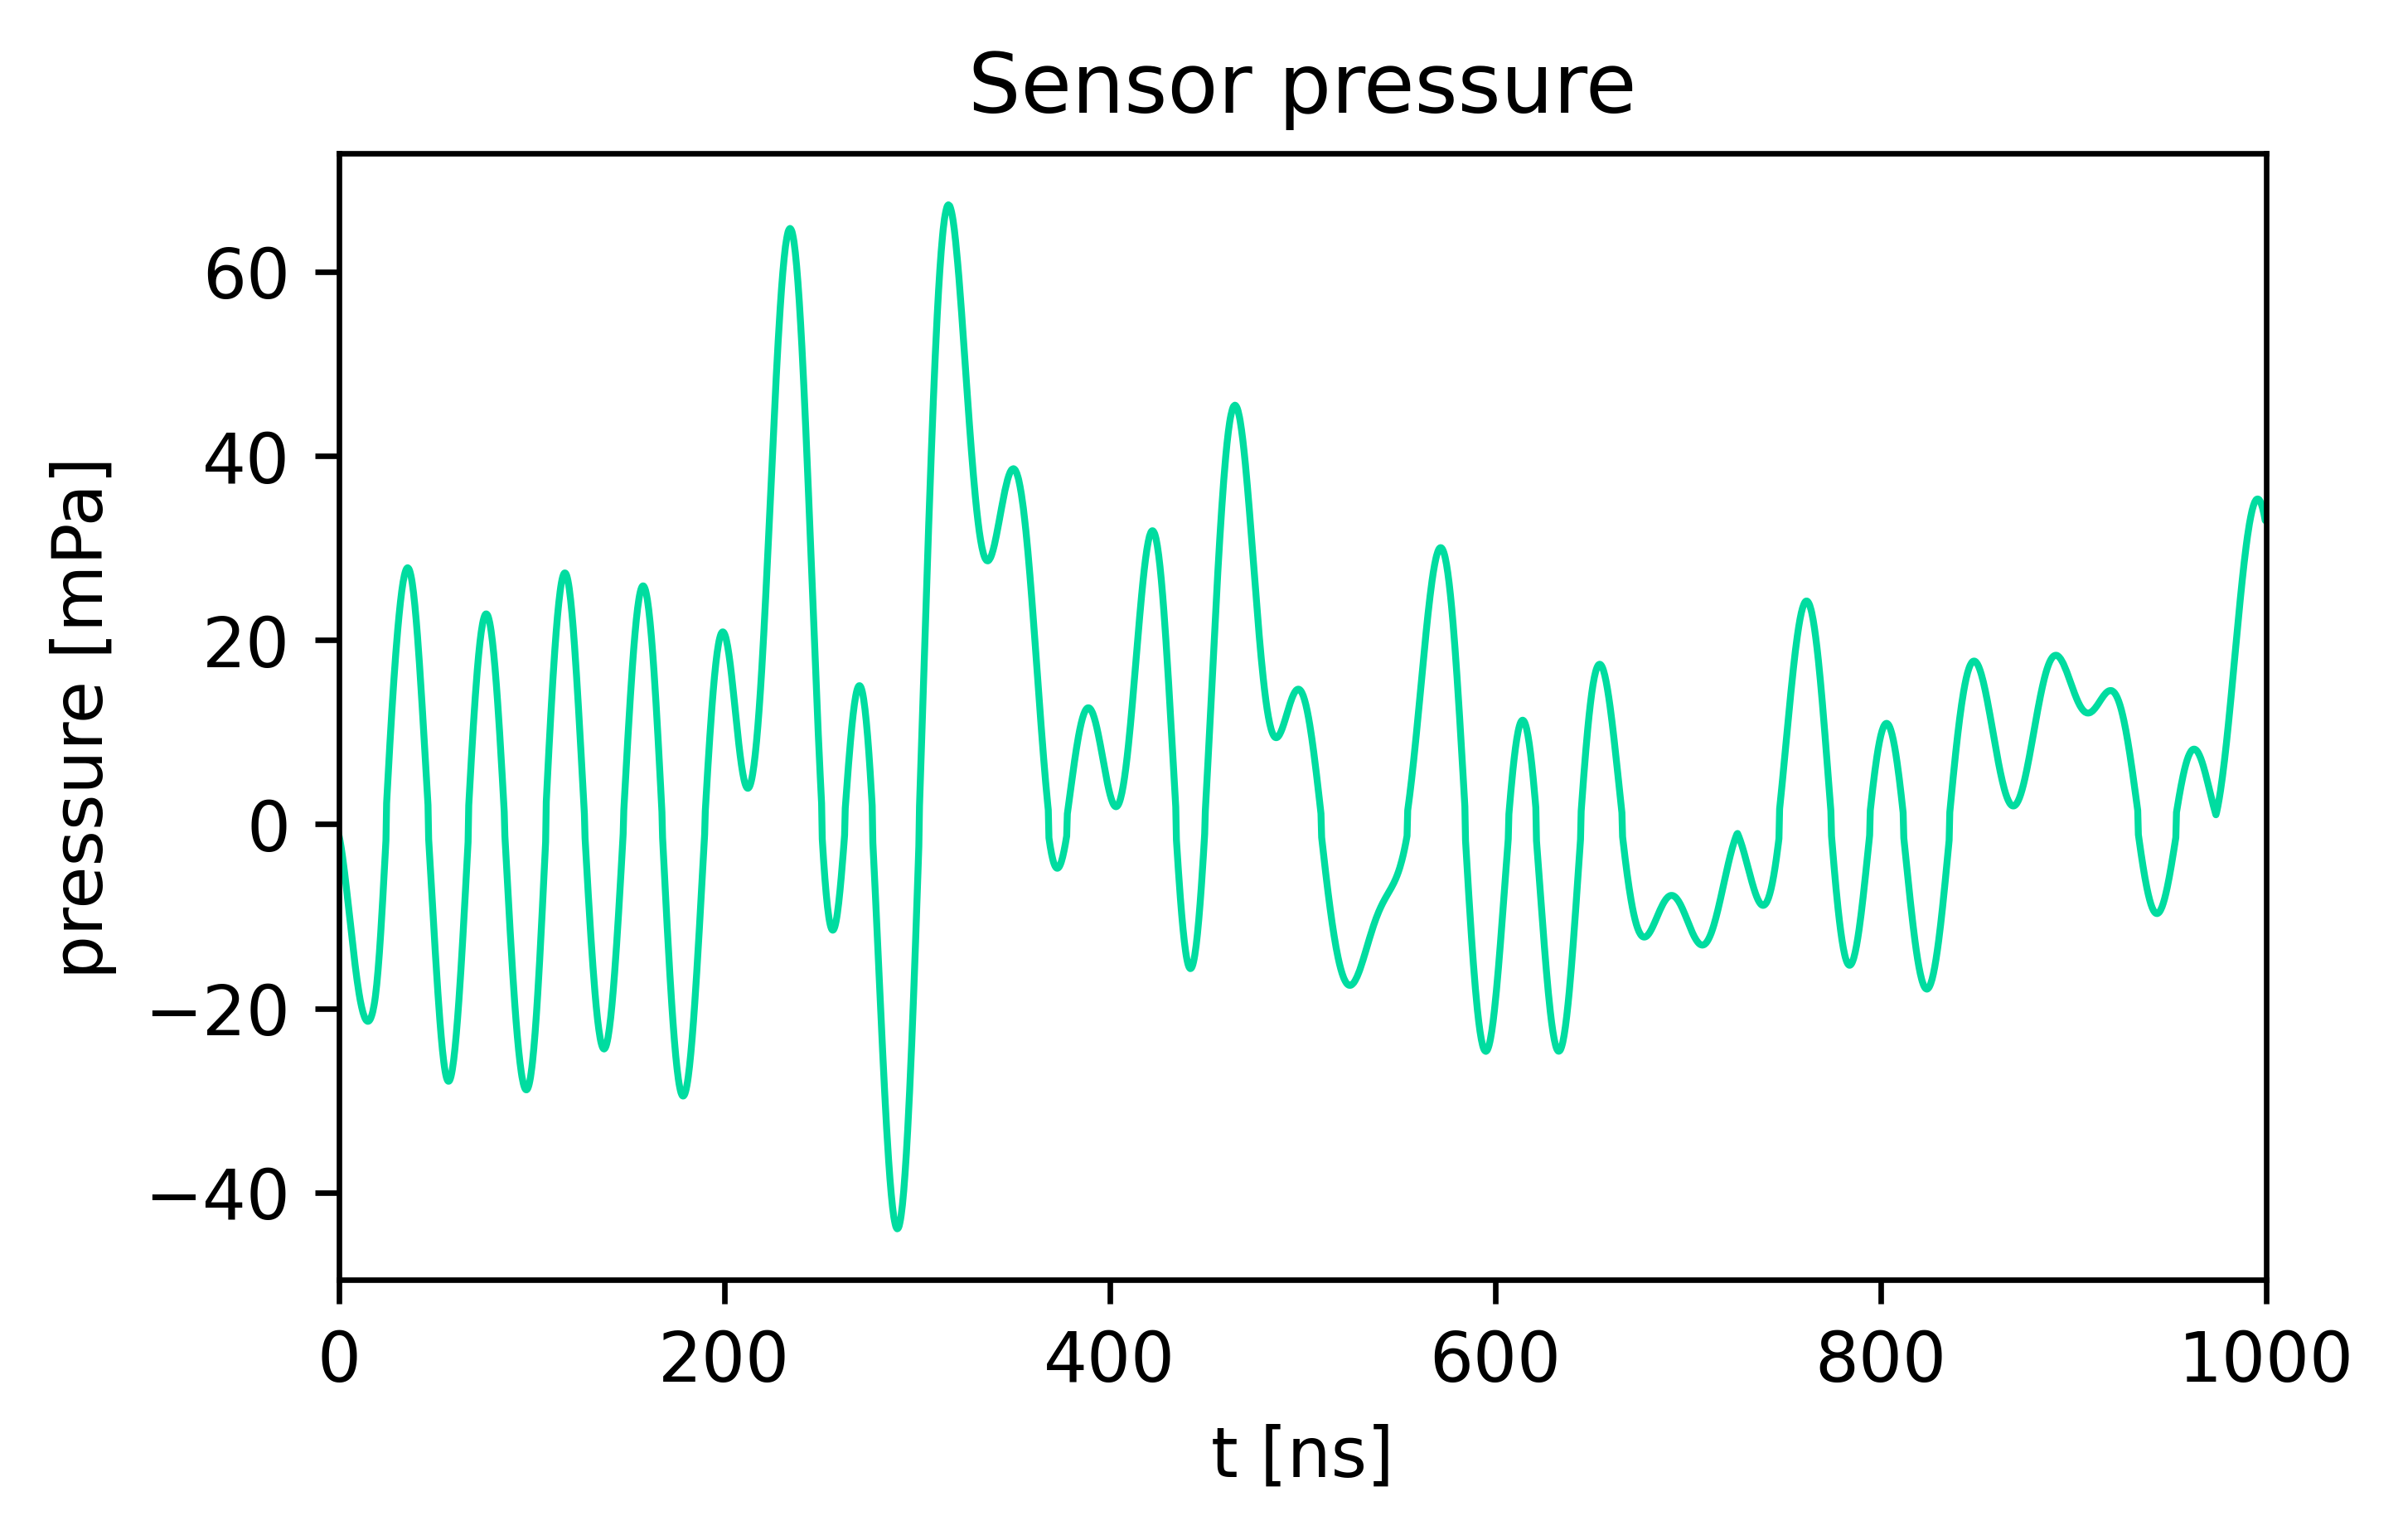

In [24]:
p_sensor = simulation_[:, -10]

figures.plot_sensor(
    p_sensor=p_sensor,
    simulation_duration=props['simulation_duration']
)

Animation of the wave propagation

**NOTE**: Computationally intensive. Make sure your work is saved in case kernel cannot handle the load.

'2022-09-10 20:01:00'

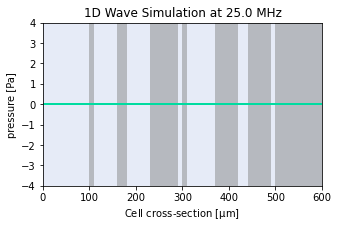

In [25]:
animation = figures.animate(simulation=simulation_, cell=cell, props=props, frames=10)

HTML(animation.to_html5_video())

figures.save_animation(animation_=animation, fps=2000)